1/1 [==============================] - 0s 335ms/step
Layer 1 output shape: (1, 256, 256, 64)


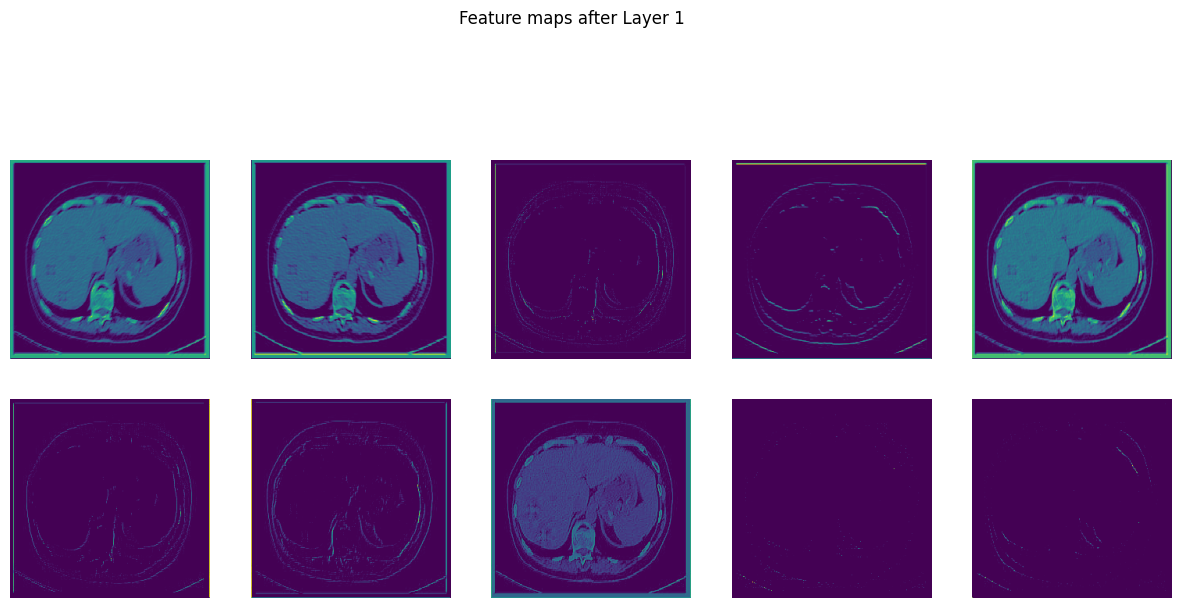

Layer 2 output shape: (1, 256, 256, 64)


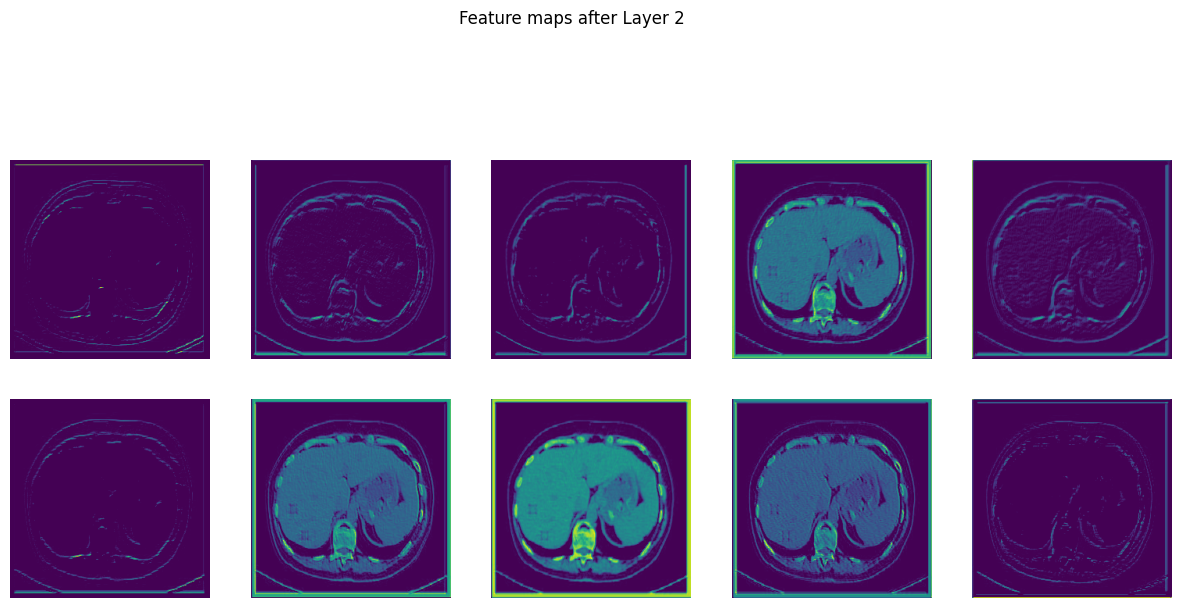

Layer 3 output shape: (1, 128, 128, 128)


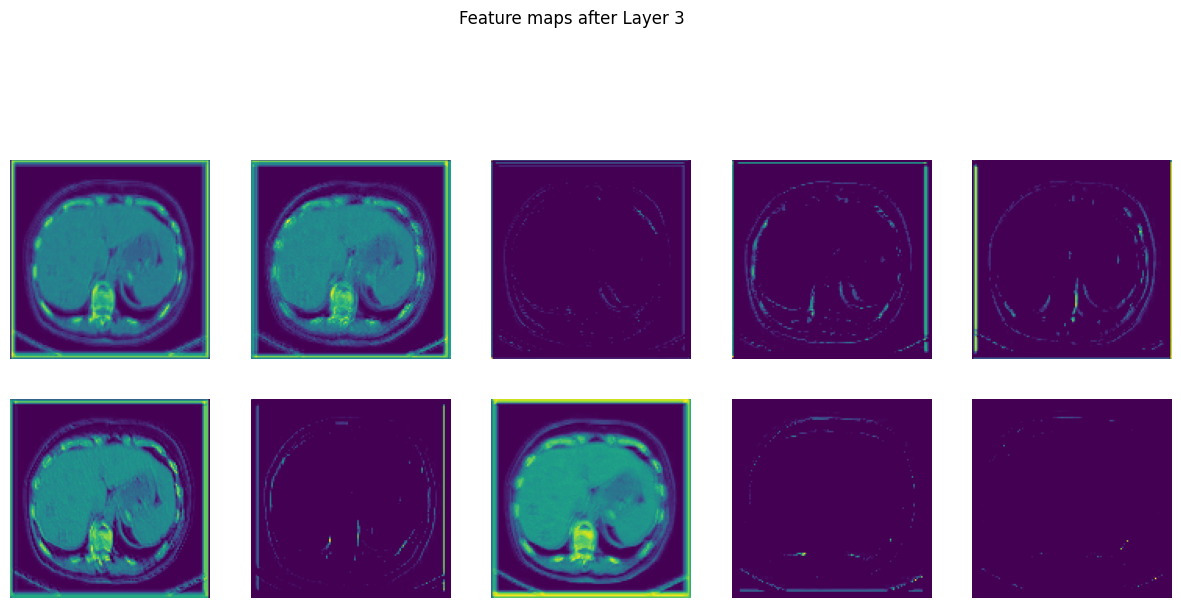

Layer 4 output shape: (1, 128, 128, 128)


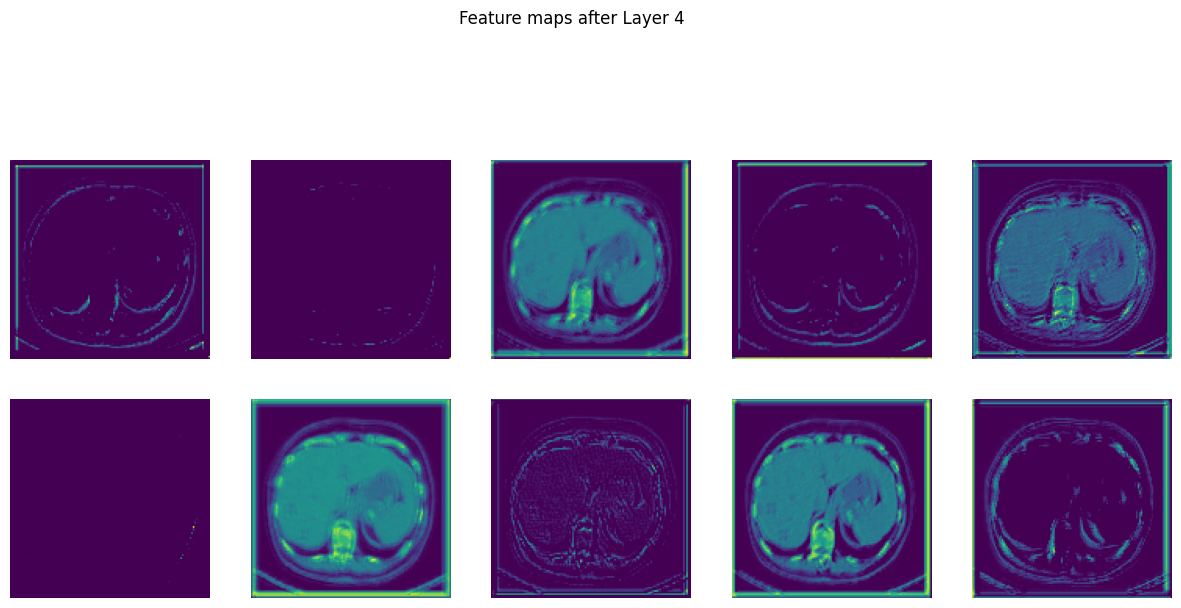

Layer 5 output shape: (1, 64, 64, 256)


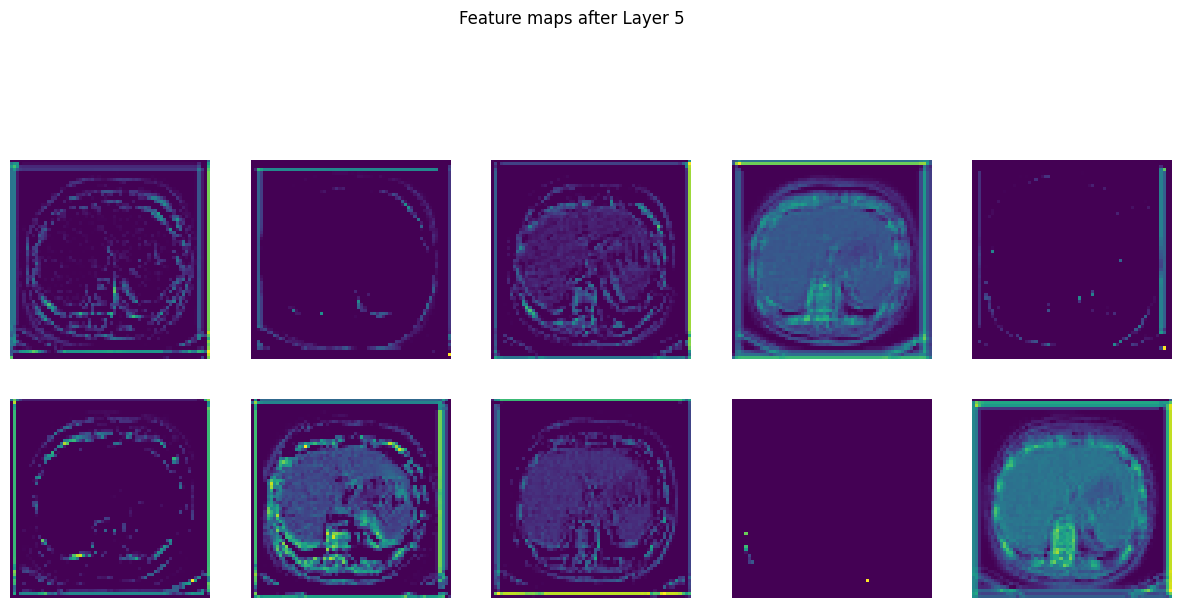

Layer 6 output shape: (1, 64, 64, 256)


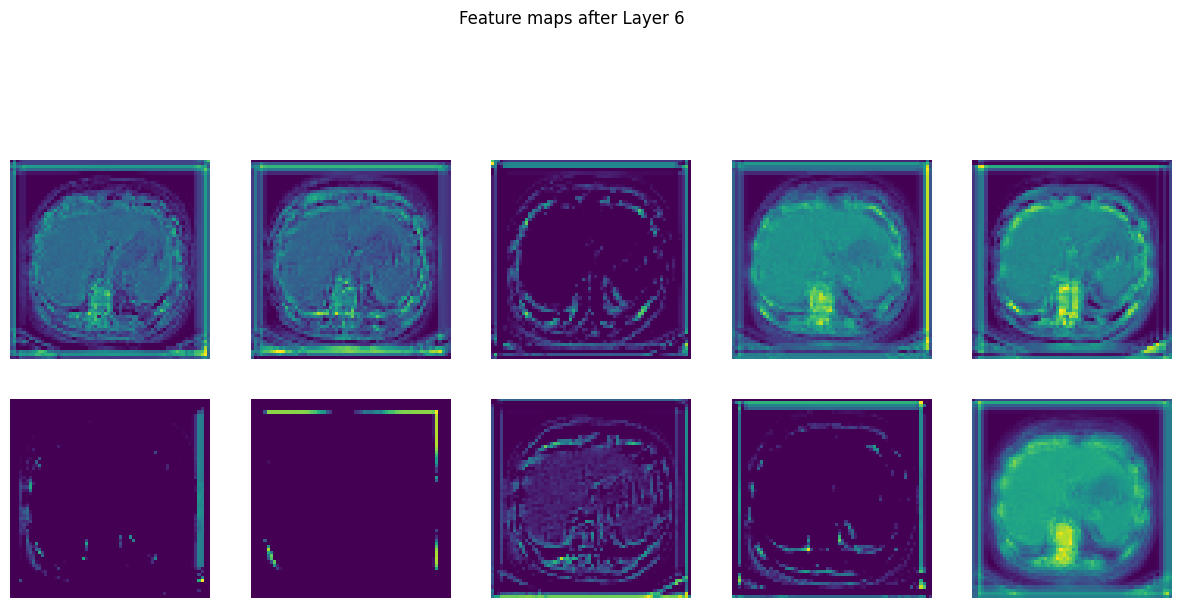

Layer 7 output shape: (1, 32, 32, 512)


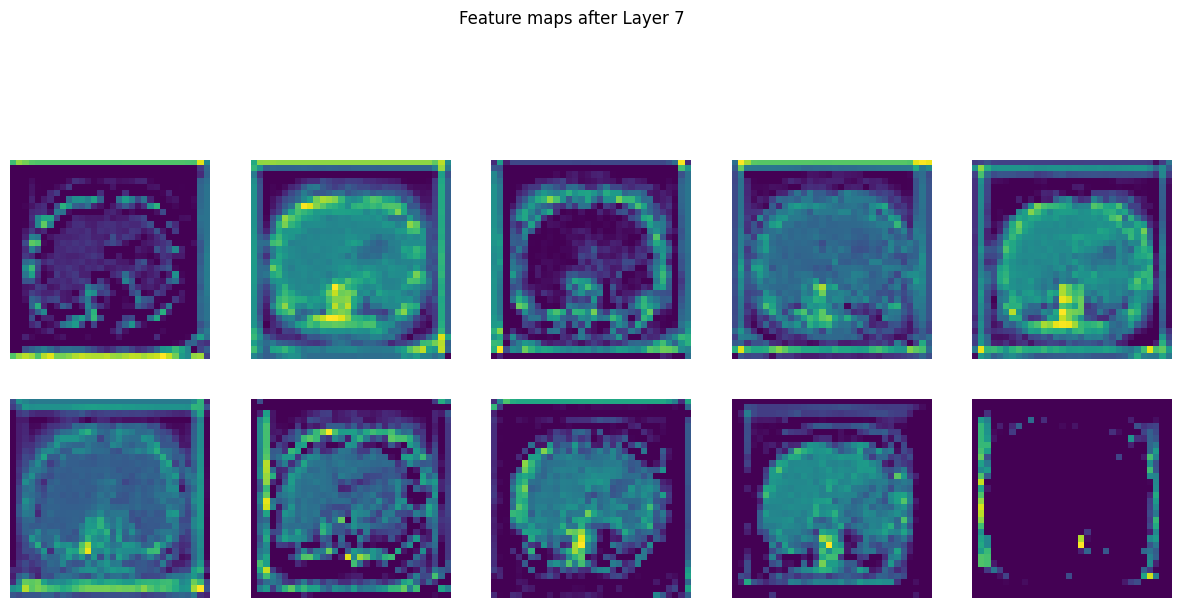

Layer 8 output shape: (1, 32, 32, 512)


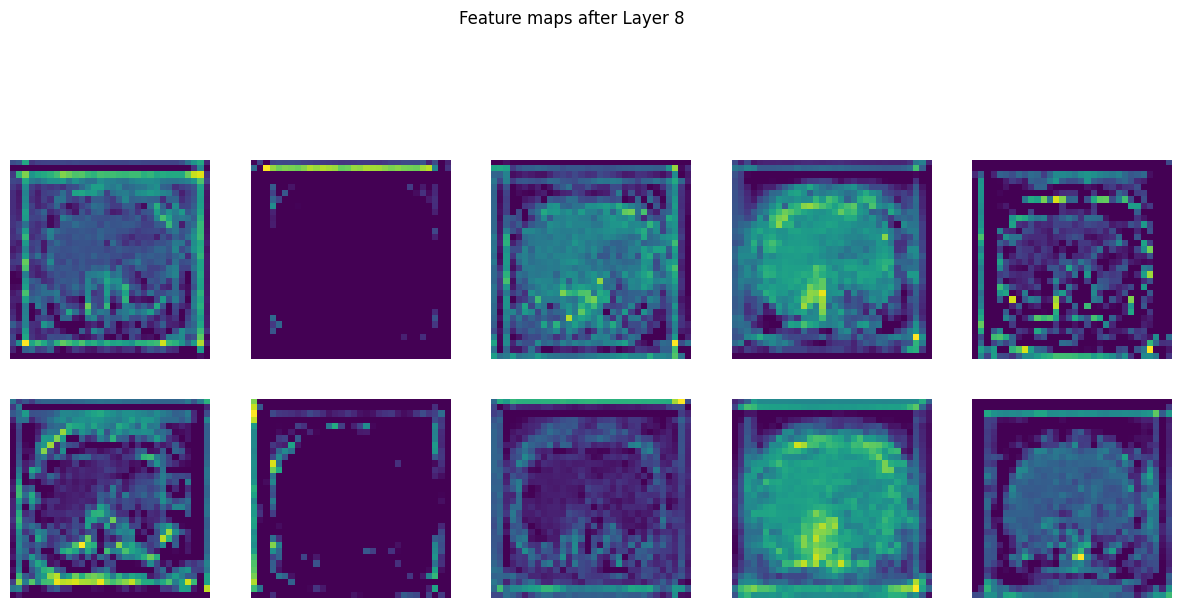

Layer 9 output shape: (1, 16, 16, 1024)


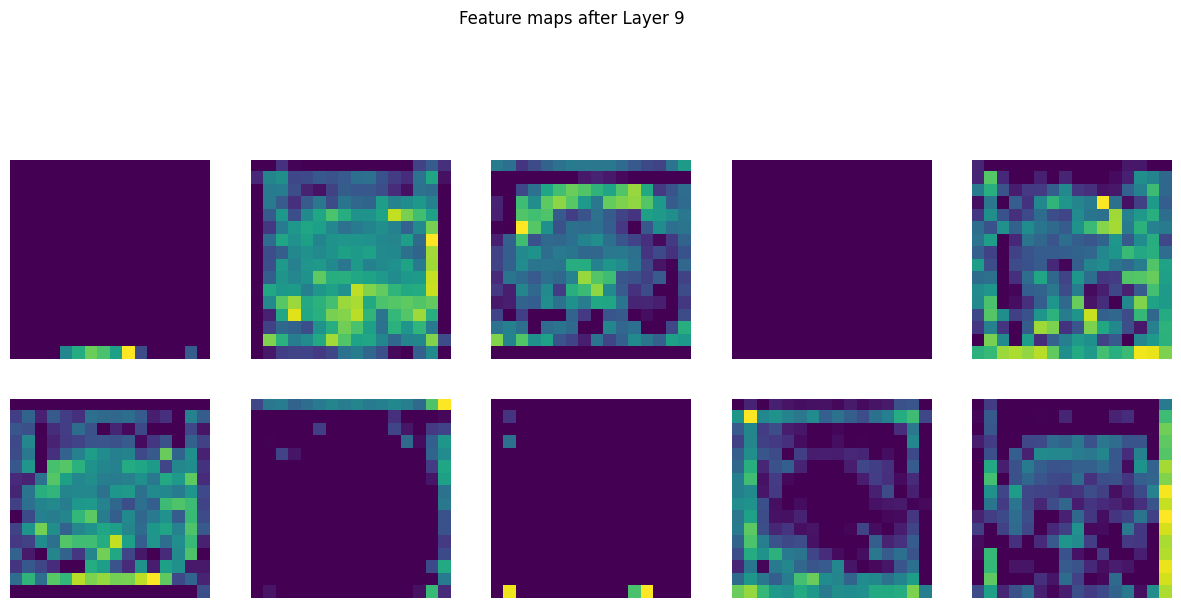

Layer 10 output shape: (1, 16, 16, 1024)


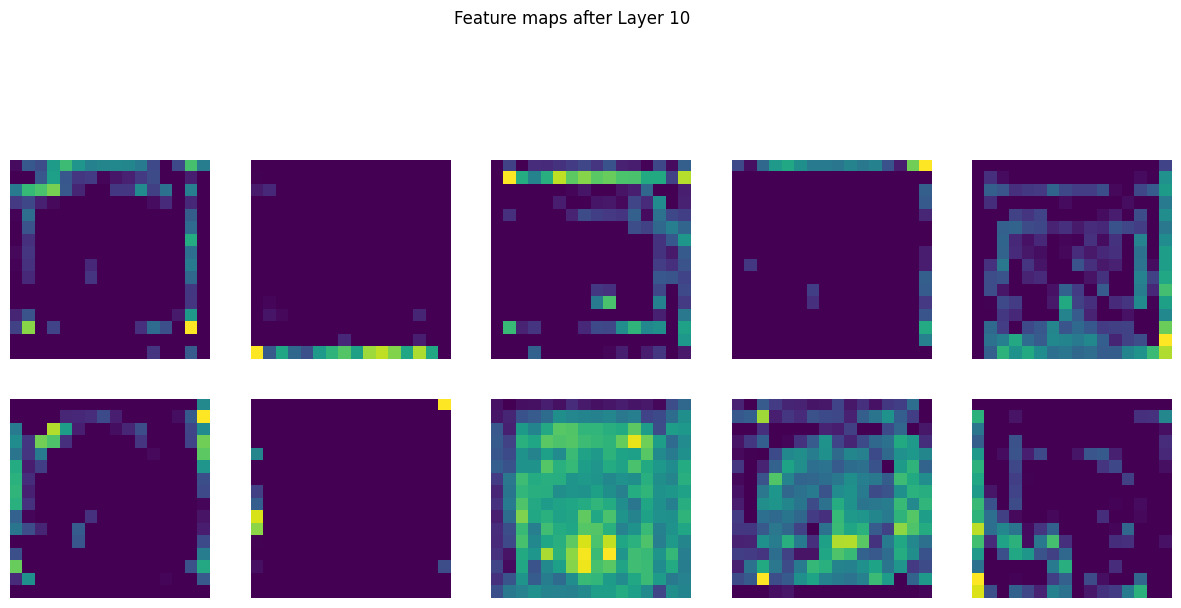

Layer 11 output shape: (1, 32, 32, 512)


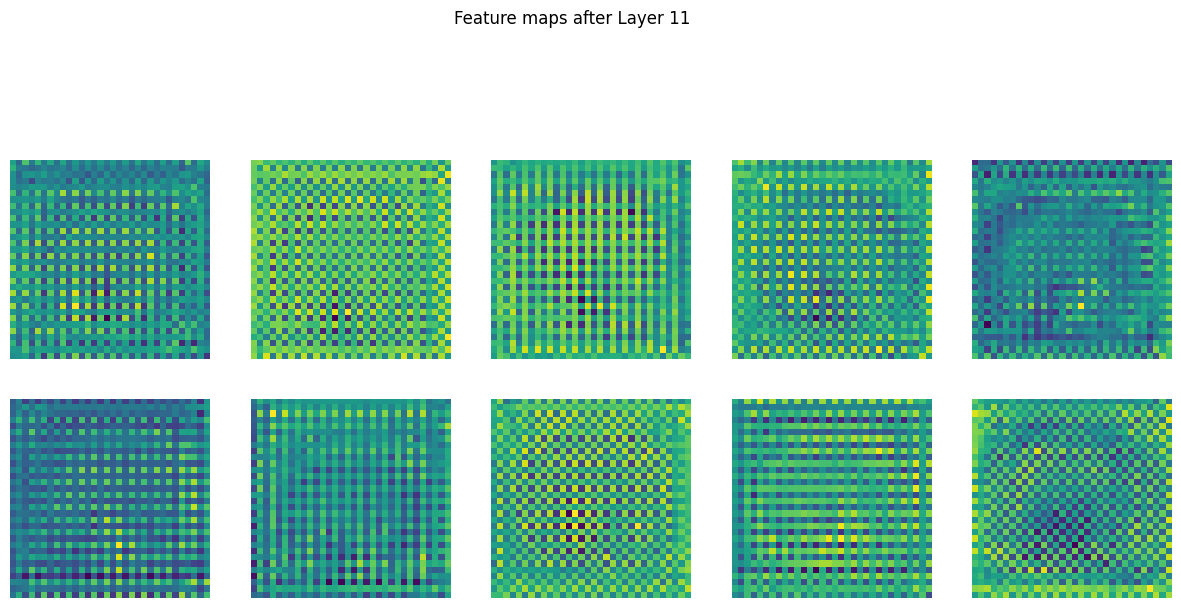

Layer 12 output shape: (1, 32, 32, 512)


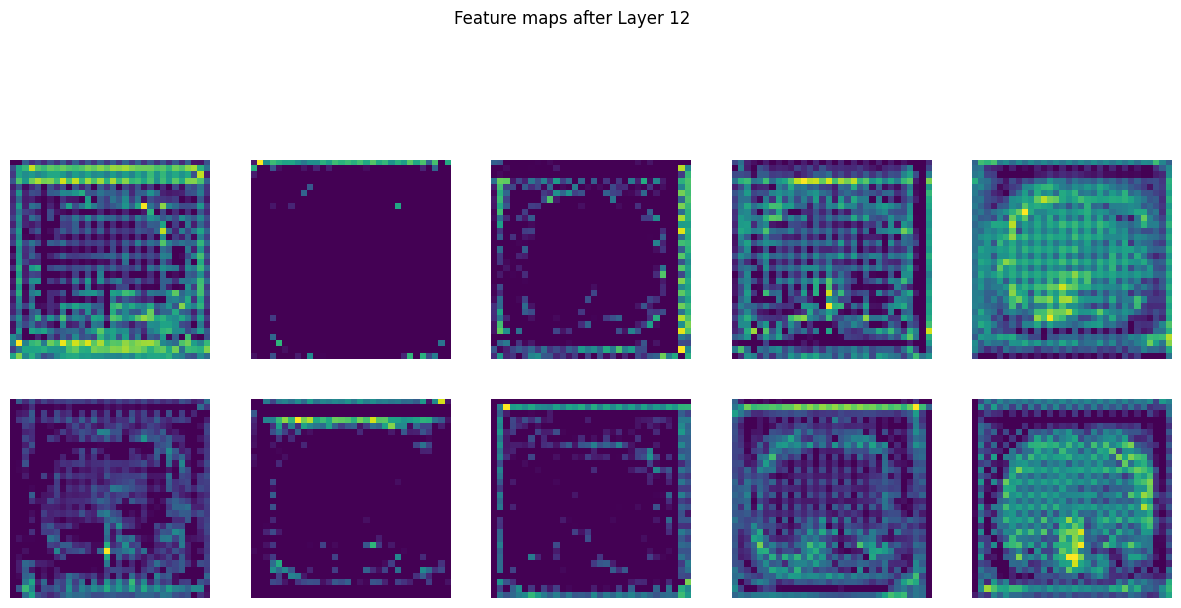

Layer 13 output shape: (1, 32, 32, 512)


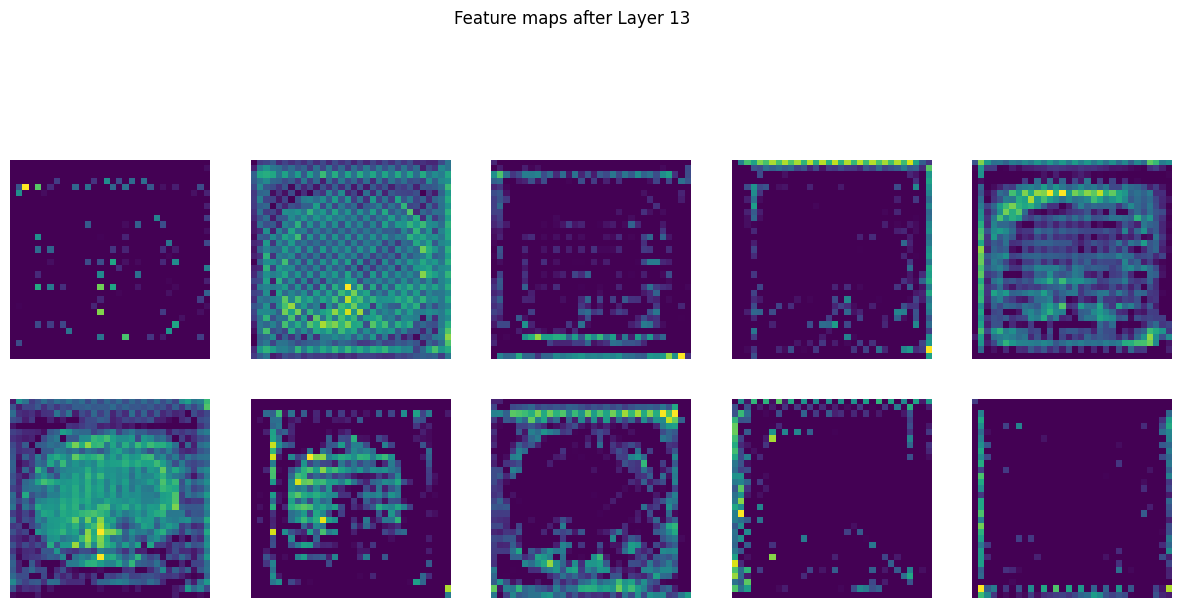

Layer 14 output shape: (1, 64, 64, 256)


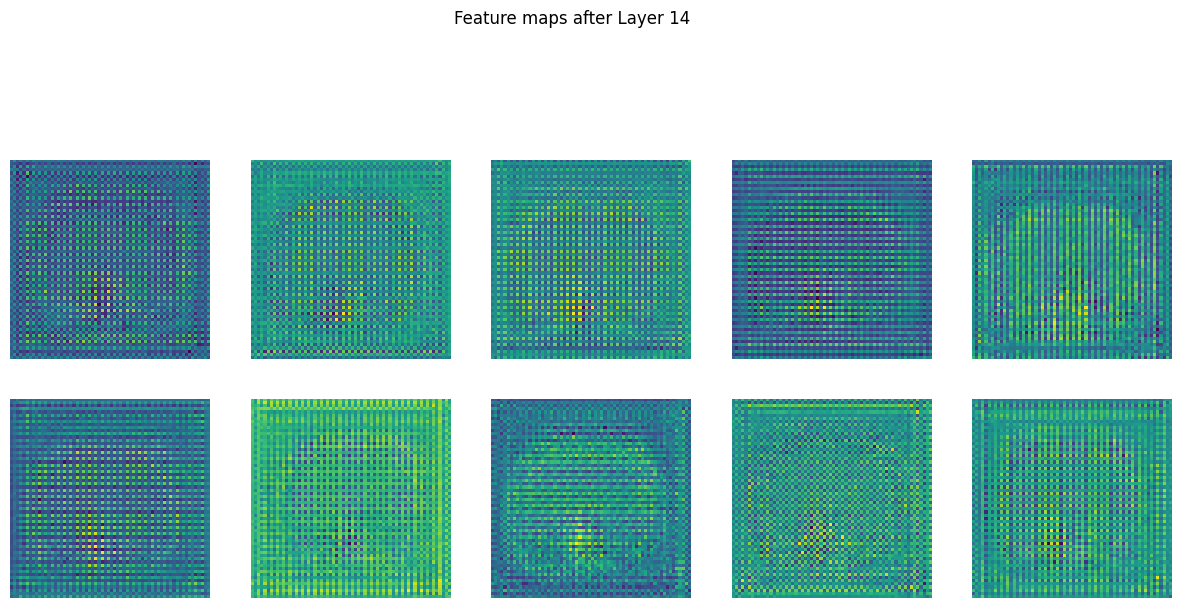

Layer 15 output shape: (1, 64, 64, 256)


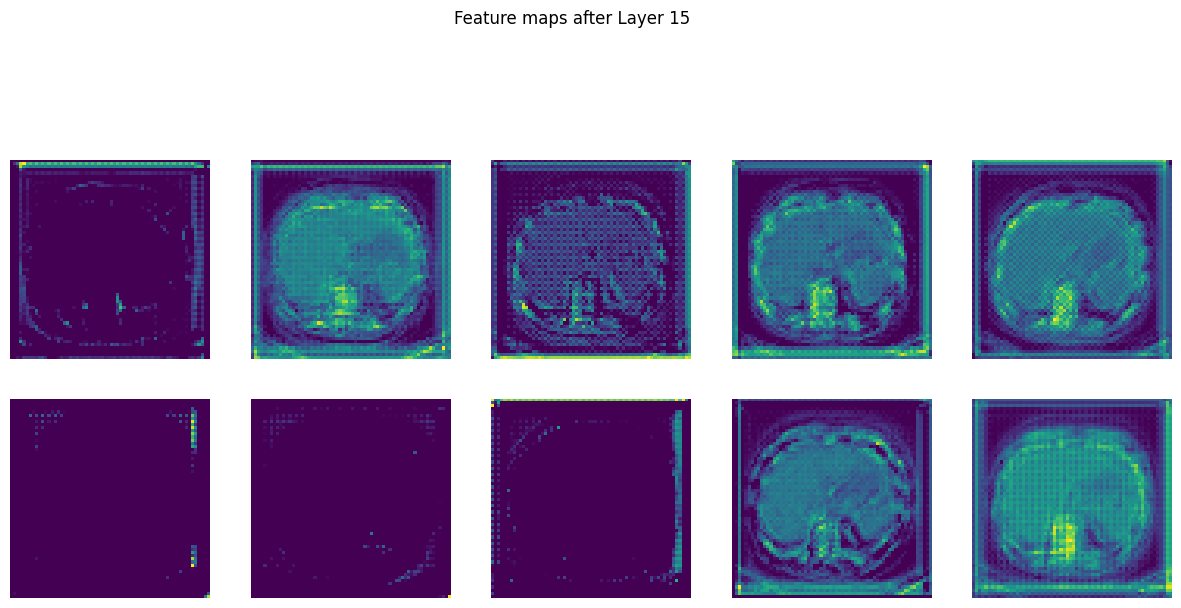

Layer 16 output shape: (1, 64, 64, 256)


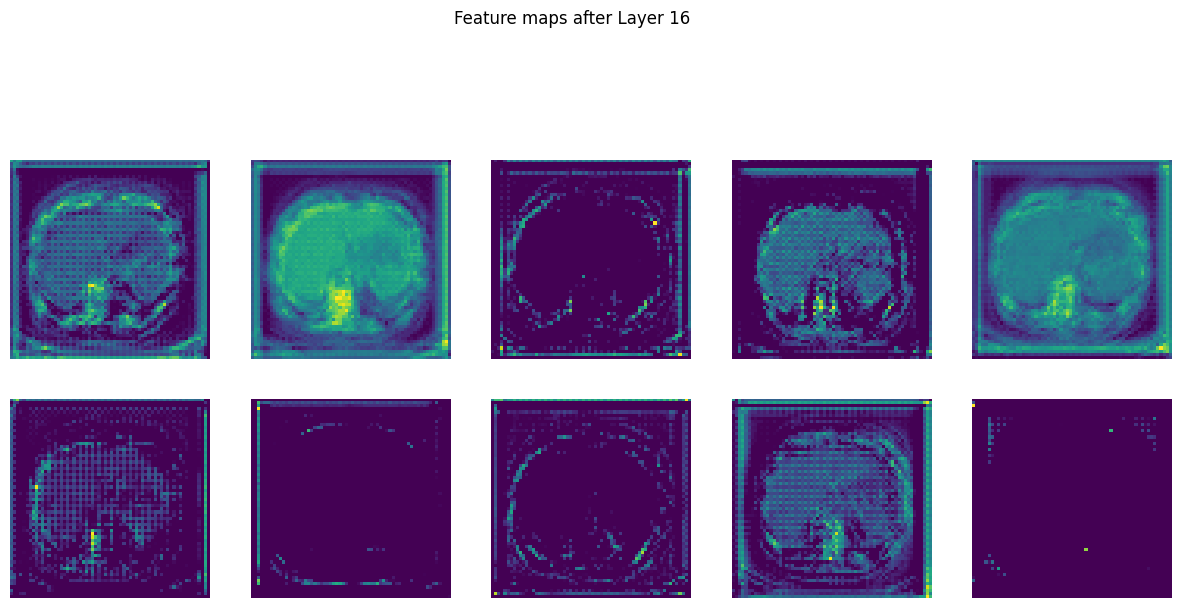

Layer 17 output shape: (1, 128, 128, 128)


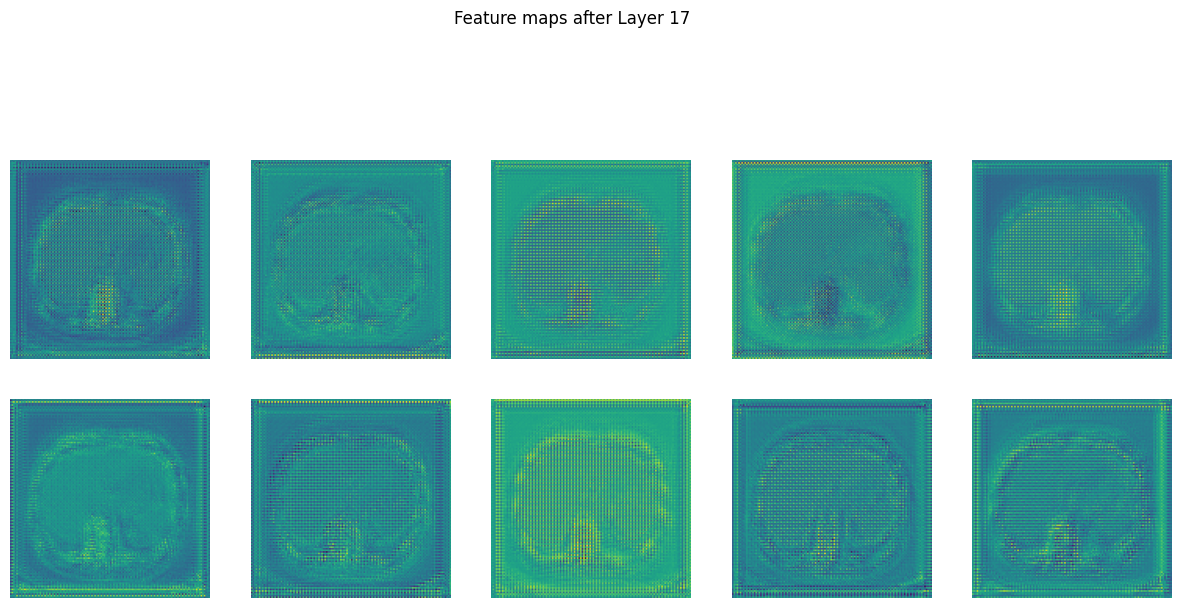

Layer 18 output shape: (1, 128, 128, 128)


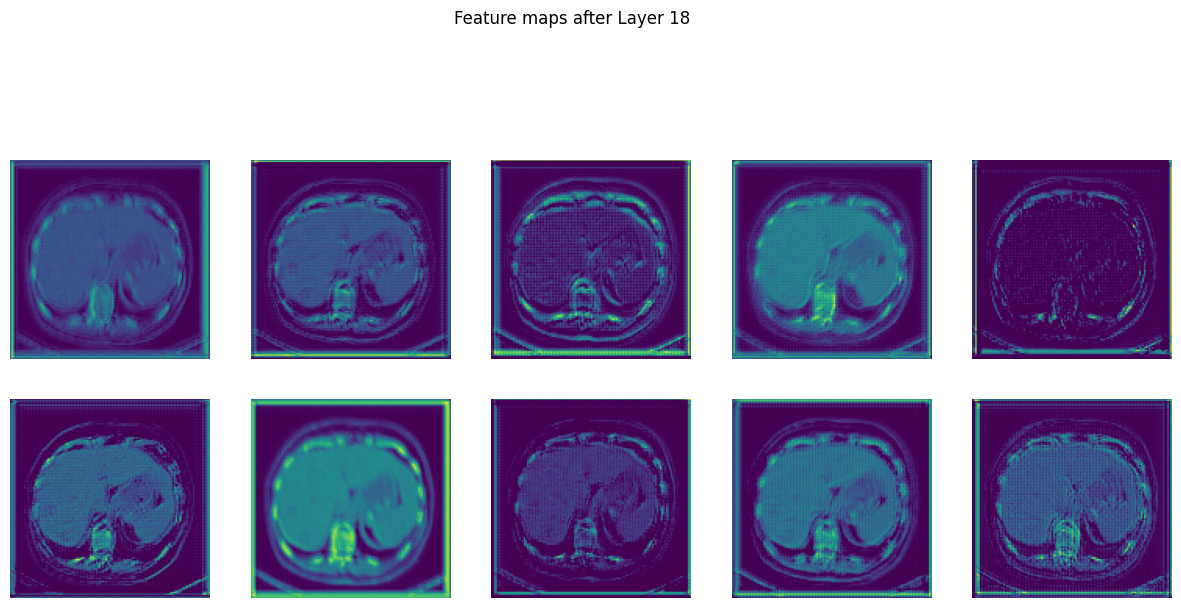

Layer 19 output shape: (1, 128, 128, 128)


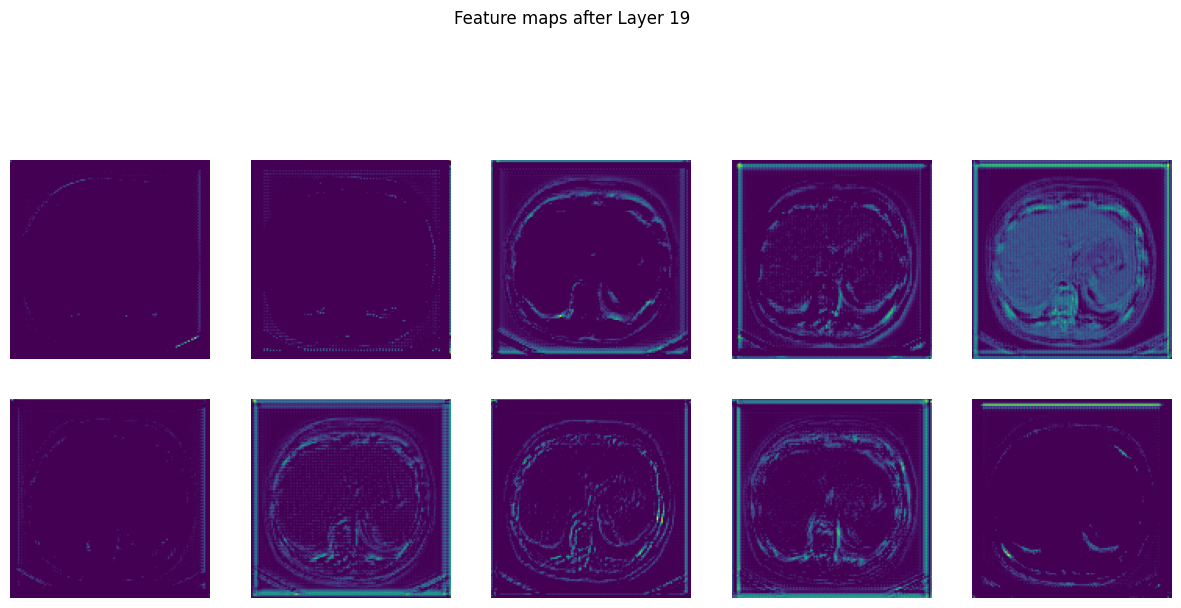

Layer 20 output shape: (1, 256, 256, 64)


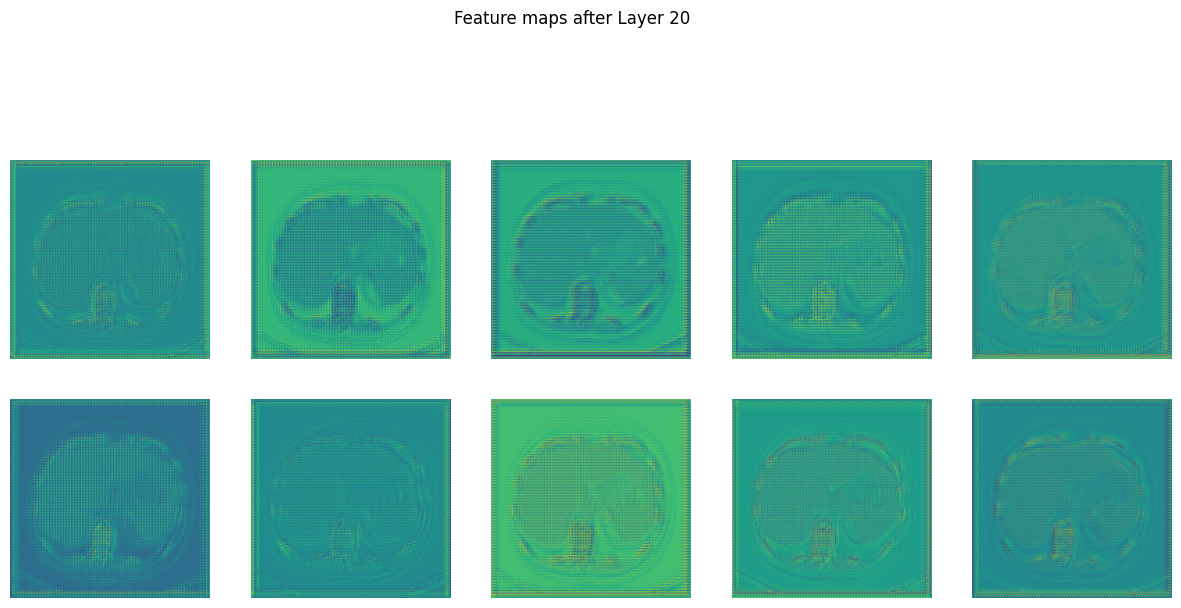

Layer 21 output shape: (1, 256, 256, 64)


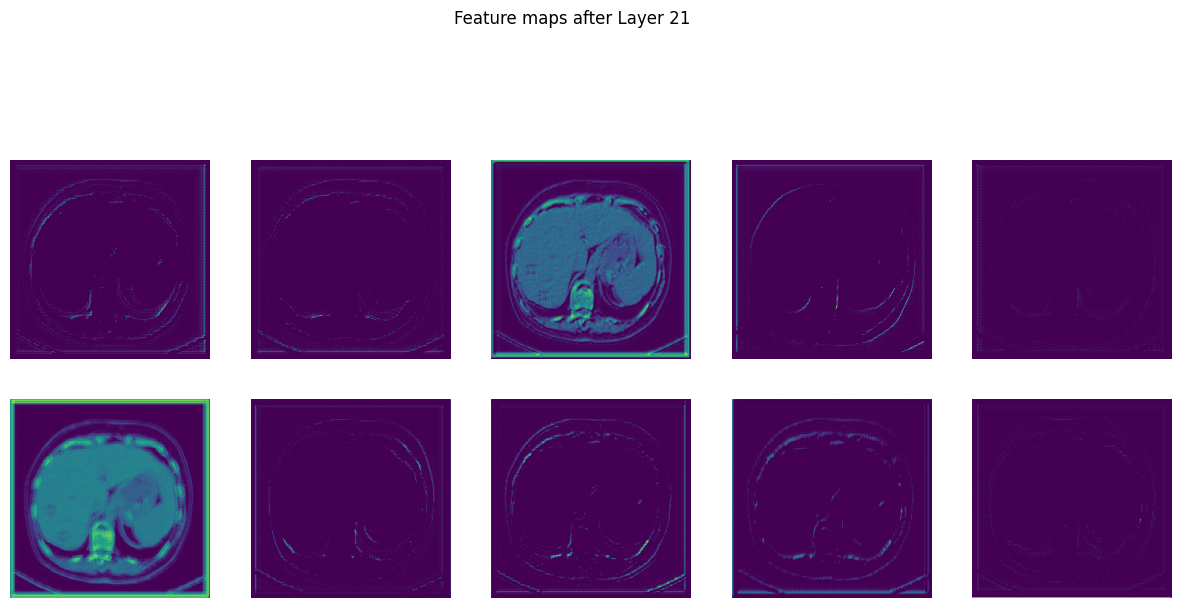

Layer 22 output shape: (1, 256, 256, 64)


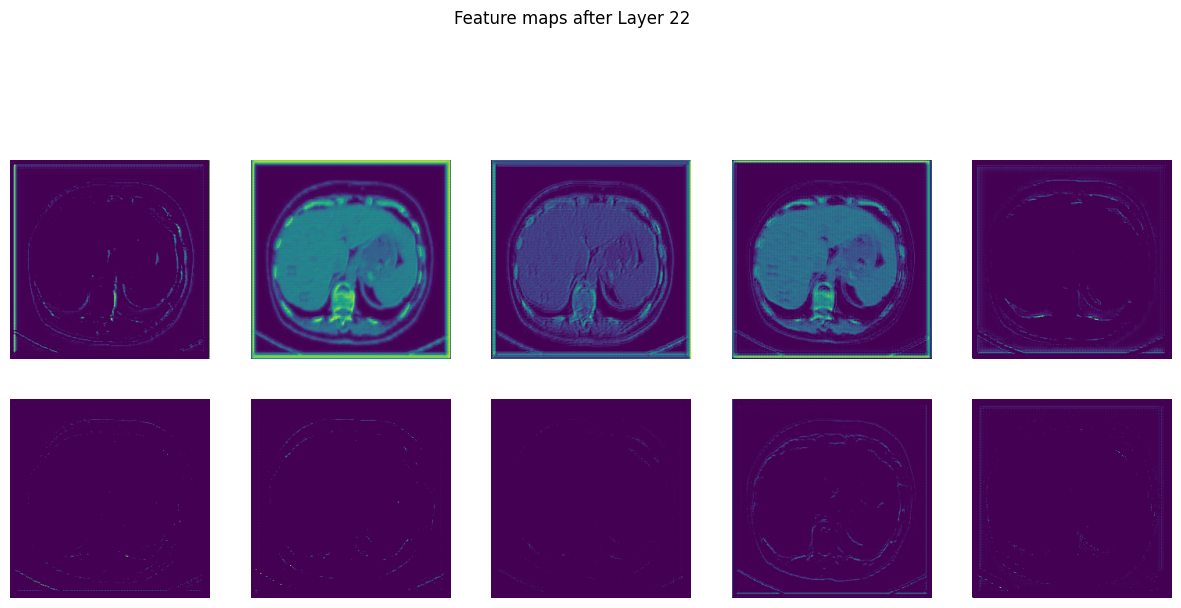

Layer 23 output shape: (1, 256, 256, 3)


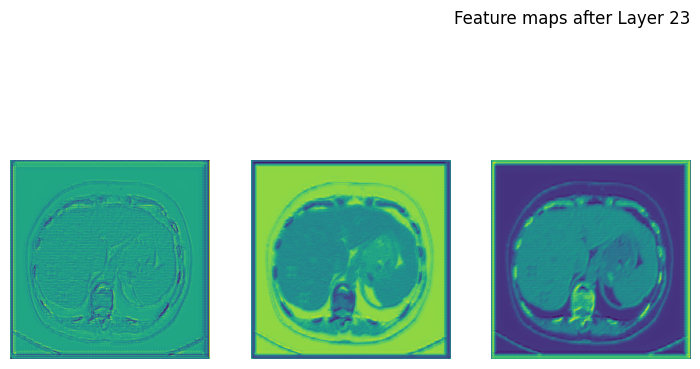

1/1 [==============================] - 0s 207ms/step


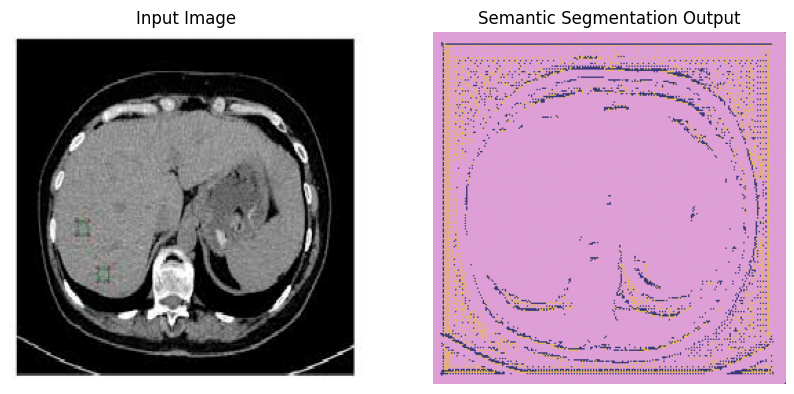

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import cv2

# Define the U-Net model for Semantic Segmentation
def unet(input_size=(256, 256, 3), num_classes=3):  # num_classes is the number of output classes
    inputs = layers.Input(input_size)

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=3)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=3)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=3)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer for multi-class segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs, outputs)

    return model

# Load and preprocess an input image
def load_image(image_path, target_size=(256, 256)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Visualize feature maps at each layer
def visualize_feature_maps(model, image_input):
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, layers.Conv2D)]
    feature_map_model = models.Model(inputs=model.input, outputs=layer_outputs)
    
    # Get the feature maps
    feature_maps = feature_map_model.predict(image_input)

    # Plot the feature maps for each layer
    for layer_idx, feature_map in enumerate(feature_maps):
        print(f"Layer {layer_idx + 1} output shape: {feature_map.shape}")
        num_feature_maps = feature_map.shape[-1]
        
        # Plot the first few feature maps (e.g., the first 10)
        plt.figure(figsize=(15, 15))
        for i in range(min(10, num_feature_maps)):
            plt.subplot(5, 5, i + 1)
            plt.imshow(feature_map[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f"Feature maps after Layer {layer_idx + 1}")
        plt.show()

# Create and compile the U-Net model
model = unet(input_size=(256, 256, 3), num_classes=3)  # Example with 3 classes
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load an image (make sure to replace 'image_path' with the actual path)
image_path = '/home/icmr/Pictures/CT.jpeg'
image_input = load_image(image_path)

# Visualize feature maps at each layer
visualize_feature_maps(model, image_input)

# Predict the segmentation result for the image
output = model.predict(image_input)

# Display the input image and the output prediction
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_input[0])
plt.title("Input Image")
plt.axis('off')

# Since the output has multiple channels, we display the class with the highest probability for each pixel
segmentation_output = np.argmax(output, axis=-1)[0]  # Taking the argmax along the last axis (channels)
plt.subplot(1, 2, 2)
plt.imshow(segmentation_output, cmap='tab20b')  # Display segmented output with a colormap
plt.title("Semantic Segmentation Output")
plt.axis('off')

plt.show()
